## IR Analysis of Personas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
#persona_queries = pd.read_csv("drive/MyDrive/ChatGPT/4_personas_topics_1-50.csv")
persona_queries = pd.read_csv("drive/MyDrive/ChatGPT/dataset.csv")
#persona_queries = pd.read_csv("drive/MyDrive/ChatGPT/datasets/dataset_QUERY_NO_EXAMPLE_NO_AGE.csv")

#persona_queries
#persona_queries['result'] = persona_queries['result'].map(eval)
#persona_queries['result'].apply(pd.Series)["queries"].apply(pd.Series)

#pd.json_normalize(persona_queries['result'])


persona_queries = persona_queries.drop("Unnamed: 0", axis = 1).rename(columns = {"query_id": "qno", "persona": "user", "topic_id": "qid"})
persona_queries["user"] = persona_queries["user"].replace(regex = {'Edith':'edith', 'Mr. John Doe':'john', 'Karen': 'karen', 'Markus':'markus'})
persona_queries = persona_queries[["qno", "user", "qid", "query"]]
uqv = persona_queries
uqv = uqv.astype({'qid': 'str'})
uqv

,qno,user,qid,query
0,1,karen,336,Black bear attack frequency
1,2,karen,336,Causes of bear attacks
2,3,karen,336,Locations of bear attacks
3,4,karen,336,Preventing bear attacks
4,5,karen,336,Surviving bear attacks
...,...,...,...,...
1876,6,edith,435,Sustainable population definition
1877,7,edith,435,Carrying capacity meaning
1878,8,edith,435,Demographic transition definition
1879,9,edith,435,Family planning explained


In [ ]:
!pip install python-terrier

In [ ]:
!pip install ranx

In [ ]:
!pip install repro-eval

In [ ]:
!wget https://th-koeln.sciebo.de/s/Agvx4PoLN3oCkZh/download -O ./drive/MyDrive/ChatGPT/index.tar.xz

In [ ]:
!tar -xf ./drive/MyDrive/ChatGPT/index.tar.xz -C ./drive/MyDrive/ChatGPT/

In [ ]:
import os
# valid for google colab
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

import pyterrier as pt
if not pt.started():
    pt.init()


from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion

dataset = pt.get_dataset('irds:nyt/trec-core-2017')

#needs to be adjusted to own system
index_ref = pt.IndexRef.of("./drive/MyDrive/ChatGPT/index/nyt")#('./index/nyt')

qrels = Qrels.from_ir_datasets("nyt/trec-core-2017")

Replacing the qid with the correct one matching the qrels data.

In [ ]:
# not needed for new dataset file
# look_up_ids = dataset.get_topics()["qid"].reset_index().rename(columns = {"index":"topic"})
# look_up_ids["topic"] = look_up_ids["topic"]

Also replacing special characters within the persona queries, otherwise the following error occurs:

```
JavaException: JVM exception occurred: Failed to process qid 423 'Milosevic's wife nickname' -- Lexical error at line 1, column 10.  Encountered: "\'" (39), after : "" org.terrier.querying.parser.QueryParserException
```

In [ ]:
# not needed for new dataset file
# uqv = uqv.merge(look_up_ids, how = "left", left_on = "qid", right_on = "topic").rename(columns = {"qid_y": "qid"}).drop(labels = ["qid_x", "topic"], axis = "columns")
# uqv = uqv[["qno", "user", "qid", "query"]]


uqv["query"] = uqv["query"].replace(to_replace = ["'","\\?","\\/"], value = "", regex = True)
uqv

,qno,user,qid,query
0,1,karen,336,Black bear attack frequency
1,2,karen,336,Causes of bear attacks
2,3,karen,336,Locations of bear attacks
3,4,karen,336,Preventing bear attacks
4,5,karen,336,Surviving bear attacks
...,...,...,...,...
1876,6,edith,435,Sustainable population definition
1877,7,edith,435,Carrying capacity meaning
1878,8,edith,435,Demographic transition definition
1879,9,edith,435,Family planning explained


The dataset contains more topics than we are currently take into account, therefore we need to slice the dataset to match our topics.

In [ ]:
list_qid_personas = uqv["qid"].unique().tolist()
dataset_sliced = dataset.get_topics('title')[dataset.get_topics('title')["qid"].isin(list_qid_personas)]

[INFO] [starting] https://trec.nist.gov/data/core/core_nist.txt
[INFO] [finished] https://trec.nist.gov/data/core/core_nist.txt: [00:00] [24.4kB] [1.65MB/s]


For some topics, less than 10 queries were produced, they need to be removed from the datasets, otherwise compiling the results is not working

In [ ]:
qid_to_remove = []

for i in list_qid_personas:
  for name in uqv["user"].unique():
    if uqv[(uqv["user"] == name) & (uqv["qid"] == i)].shape[0] == 10:
      pass
    else:
      qid_to_remove.append(i)
      print(name, i)

qid_to_remove = set(qid_to_remove)
print(qid_to_remove)

dataset_sliced_revised = dataset_sliced[~dataset_sliced["qid"].isin(qid_to_remove)]
uqv_revised = uqv[~uqv["qid"].isin(qid_to_remove)]

karen 336
markus 321
john 321
edith 321
john 325
markus 344
edith 344
edith 310
karen 353
markus 353
edith 353
karen 367
edith 367
john 362
markus 404
john 404
karen 427
markus 620
markus 423
karen 626
markus 626
edith 626
{'626', '423', '404', '427', '353', '321', '362', '336', '310', '325', '620', '367', '344'}


In [ ]:
bm25 = pt.BatchRetrieve(index_ref, wmodel='BM25')
# slicing of dataset needs to be adjusted depending on the persona queries
baseline = bm25(dataset_sliced_revised)
pt.io.write_results(baseline, 'baseline', format='trec', append=False)
baseline_ranx = Run.from_file('baseline', kind='trec')
baseline_ranx.name = 'BM25'

In [ ]:
run_dict = {}

for name in ['edith', 'john', 'karen', 'markus']:
  runs = []

  for i in range(1, 11):

    queries = uqv_revised[(uqv_revised['user'] == name) & (uqv_revised['qno']==i)][['qid', 'query']]

    pt.io.write_results(bm25(queries), 'bm25_'+ name + "_qno_" + str(i), format='trec', append=False)

    ranx_key = name + "_" + str(i)
    ranx = Run.from_file('bm25_' + name + "_qno_" + str(i), kind='trec')
    ranx.name = ranx_key

    runs.append({i: ranx})

  run_dict[name] = runs

In [ ]:
run_dict["edith"][0].keys()

dict_keys([1])

In [ ]:
# edith_ranx = Run.from_file('bm25_edith', kind='trec')
# edith_ranx.name = 'Edith'

# john_ranx = Run.from_file('bm25_john', kind='trec')
# john_ranx.name = 'John'

# karen_ranx = Run.from_file('bm25_karen', kind='trec')
# karen_ranx.name = 'Karen'

# markus_ranx = Run.from_file('bm25_markus', kind='trec')
# markus_ranx.name = 'Markus'

It only works if they have the same ids and also the same number. So if only working with partly results for personas, the qrels must be sliced to the same sample.

In [ ]:
import ir_datasets
qrels_dataset = ir_datasets.load("nyt/trec-core-2017").qrels_dict()

qrels_dataset_sub = {}
for id in uqv_revised["qid"]:
  qrels_dataset_sub[id] = qrels_dataset[id]

In [ ]:
edith_john_ranx_collection = [run_dict[name][i-1][i] for name in [ 'edith', 'john'] for i in range(1,11)]

report = compare(
    qrels=Qrels.from_dict(qrels_dataset_sub),
    runs=[baseline_ranx] + edith_john_ranx_collection,
    metrics=["ndcg", "map", "precision@10", "bpref"],
    max_p=0.05
)

report

#    Model     NDCG                       MAP                        P@10                     BPref
---  --------  -------------------------  -------------------------  -----------------------  ----------------------
a    BM25      0.406ᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.174ᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.454ᶜᵈᵉᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.253ᶜᵈᶠʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ
b    edith_1   0.323ᵈʰʲᵒ                  0.131ᵈʰ                    0.376ᵈᵉᵍʰᶦᵏᵒ۹            0.222ᵒ
c    edith_2   0.272                      0.103                      0.303                    0.172
d    edith_3   0.267                      0.090                      0.265                    0.194
e    edith_4   0.290                      0.110                      0.265                    0.204
f    edith_5   0.269                      0.109                      0.349ᵍᵏᵒ۹                0.180
g    edith_6   0.269                      0.094                      0.235                    0.199
h    edith_7   0.245                      0.085                  

In [ ]:
edith_john_ranx_collection = [run_dict[name][i-1][i] for name in ['karen', 'markus'] for i in range(1,11)]

report = compare(
    qrels=Qrels.from_dict(qrels_dataset_sub),
    runs=[baseline_ranx] + edith_john_ranx_collection,
    metrics=["ndcg", "map", "precision@10", "bpref"],
    max_p=0.05
)

report

#    Model      NDCG                       MAP                        P@10                       BPref
---  ---------  -------------------------  -------------------------  -------------------------  ----------------------
a    BM25       0.406ᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.174ᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.454ᵇᶜᵈᵉᶠᵍʰᶦʲᵏˡᵐⁿᵒᵖ۹ʳˢᵗᵘ  0.253ᶜᵈᵉᶠᵍᶦʲᵏᵐⁿᵒᵖ۹ʳˢᵗᵘ
b    karen_1    0.314ᵐⁿᵒᵖ                  0.126                      0.368ʲᵏᵒᵖˢᵗ                0.220ˢ
c    karen_2    0.260                      0.104                      0.314                      0.181
d    karen_3    0.269                      0.117                      0.343ᵒ                     0.200
e    karen_4    0.264                      0.108                      0.295                      0.184
f    karen_5    0.273                      0.117                      0.316                      0.200
g    karen_6    0.299ᵖ                     0.116                      0.305                      0.204
h    karen_7    0.285                 

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('darkgrid')

# delta = pd.DataFrame.from_dict(edith_ranx.scores) - pd.DataFrame.from_dict(baseline_ranx.scores)
# ax = delta['ndcg'].sort_values(ascending=False).plot(figsize=(12,4), kind='bar')
# ax.set_xlabel("Topics")
# ax.set_ylabel('$\Delta$ nDCG')
# plt.title("Edith vs. Baseline")
# plt.show()

In [ ]:
results_df = pd.DataFrame()

for name in ['edith', 'john', 'karen', 'markus']:
  for i in range(1,10):
    df_temp_1 = pd.DataFrame.from_dict(run_dict[name][i-1][i].scores) - pd.DataFrame.from_dict(baseline_ranx.scores)
    df_temp_1 = df_temp_1.reset_index(names = "qid")
    df_temp_2 = pd.DataFrame({"name": [name + "_" + str(i)], "persona": name})

    df_temp = df_temp_1.join(df_temp_2, how = "cross")
    results_df = pd.concat([results_df, df_temp], axis = "index")

results_df

,qid,ndcg,map,precision@10,bpref,name,persona
0,307,0.001836,-0.000148,0.1,-0.004710,edith_1,edith
1,330,-0.446091,-0.078958,-0.2,-0.097382,edith_1,edith
2,341,-0.017258,-0.008202,-0.2,0.023011,edith_1,edith
3,345,-0.022587,-0.032475,0.0,-0.006202,edith_1,edith
4,347,0.023719,0.024706,0.1,0.036068,edith_1,edith
...,...,...,...,...,...,...,...
32,445,0.111939,0.030269,0.1,0.073388,markus_9,markus
33,614,-0.057732,-0.040062,0.1,-0.034937,markus_9,markus
34,646,-0.792272,-0.526594,-0.9,-0.604466,markus_9,markus
35,677,-0.602678,-0.602651,-0.7,-0.459184,markus_9,markus


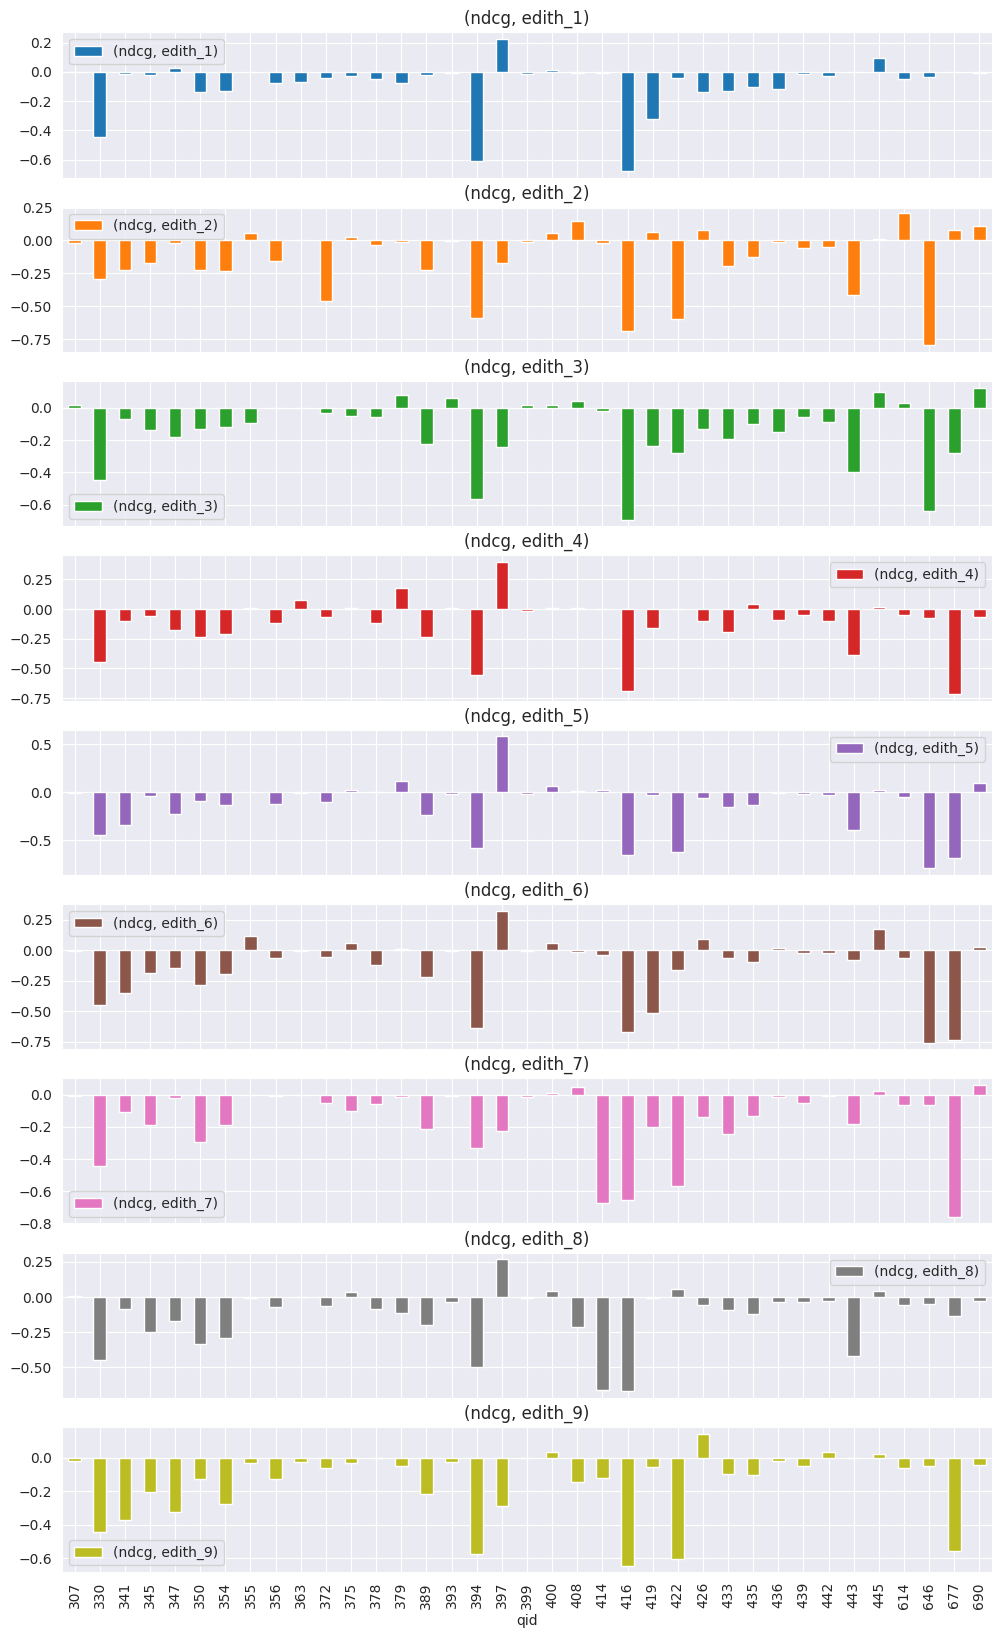

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


ax = results_df[results_df["persona"]=="edith"][["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,20), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


ax = results_df[results_df["persona"]=="karen"][["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,20), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


ax = results_df[results_df["persona"]=="markus"][["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,20), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


ax = results_df[results_df["persona"]=="john"][["qid","ndcg","name"]].groupby(["qid","name"]).agg("sum").unstack().plot(figsize=(12,20), kind='bar', subplots = True)
#ax.set_xlabel("Topics")
#ax.set_ylabel('$\Delta$ nDCG')
#plt.title("Personas vs. Baseline")
plt.show()

In [ ]:
import math
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion

b = 2
bq = 4

qrels = qrels_dataset_sub

# run_dict[name][i-1][i].scores

run_store_edith = {}
for q in range(1, 11):
    run_store_edith[q] = Run.from_file("./bm25_edith_qno_" + str(q), kind='trec').to_dict()


qrels_store = {}
for k,v in qrels.items():
    for _v in v:
        qrels_store[(k,_v)] = qrels.get(k).get(_v)


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels_store.get(topic,result)
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

data = {}
topics = qrels.keys()

for num_queries in range(1,11):
    _data = {}
    for num_docs in range(1, 100):
        run = {}
        for topic in topics:
            sdcg = 0.0
            for q in range(1, num_queries):
                results = list(run_store_edith.get(q).get(topic).keys())[:num_docs]
                sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            run[topic] = sdcg
        avg_sdcg = sum([sdcg for sdcg in run.values()])/len(topics)
        _data[num_docs] = avg_sdcg
    data[str(num_queries) + ' queries'] = _data

pd.DataFrame.from_dict(data).to_csv('sdcg_edith.csv')

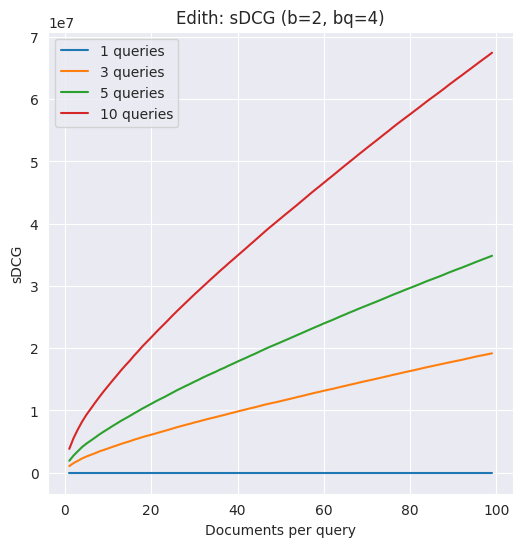

In [ ]:
df = pd.read_csv('sdcg_edith.csv', index_col=0)
ax = df[['1 queries', '3 queries', '5 queries', '10 queries']].plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("Edith: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import math
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion

b = 2
bq = 4

qrels = qrels_dataset_sub

# run_dict[name][i-1][i].scores

run_store_karen = {}
for q in range(1, 11):
    run_store_karen[q] = Run.from_file("./bm25_karen_qno_" + str(q), kind='trec').to_dict()


qrels_store = {}
for k,v in qrels.items():
    for _v in v:
        qrels_store[(k,_v)] = qrels.get(k).get(_v)


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels_store.get(topic,result)
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

data = {}
topics = qrels.keys()

for num_queries in range(1,11):
    _data = {}
    for num_docs in range(1, 100):
        run = {}
        for topic in topics:
            sdcg = 0.0
            for q in range(1, num_queries):
                results = list(run_store_karen.get(q).get(topic).keys())[:num_docs]
                sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            run[topic] = sdcg
        avg_sdcg = sum([sdcg for sdcg in run.values()])/len(topics)
        _data[num_docs] = avg_sdcg
    data[str(num_queries) + ' queries'] = _data

pd.DataFrame.from_dict(data).to_csv('sdcg_karen.csv')

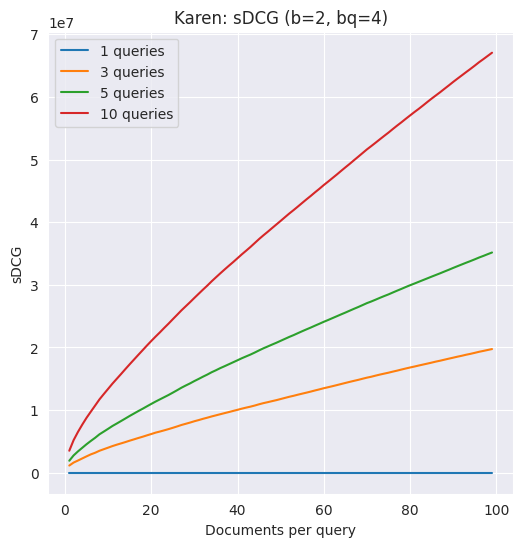

In [ ]:
df = pd.read_csv('sdcg_karen.csv', index_col=0)
ax = df[['1 queries', '3 queries', '5 queries', '10 queries']].plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("Karen: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import math
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion

b = 2
bq = 4

qrels = qrels_dataset_sub

# run_dict[name][i-1][i].scores

run_store_john = {}
for q in range(1, 11):
    run_store_john[q] = Run.from_file("./bm25_john_qno_" + str(q), kind='trec').to_dict()


qrels_store = {}
for k,v in qrels.items():
    for _v in v:
        qrels_store[(k,_v)] = qrels.get(k).get(_v)


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels_store.get(topic,result)
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

data = {}
topics = qrels.keys()

for num_queries in range(1,11):
    _data = {}
    for num_docs in range(1, 100):
        run = {}
        for topic in topics:
            sdcg = 0.0
            for q in range(1, num_queries):
                results = list(run_store_john.get(q).get(topic).keys())[:num_docs]
                sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            run[topic] = sdcg
        avg_sdcg = sum([sdcg for sdcg in run.values()])/len(topics)
        _data[num_docs] = avg_sdcg
    data[str(num_queries) + ' queries'] = _data

pd.DataFrame.from_dict(data).to_csv('sdcg_john.csv')

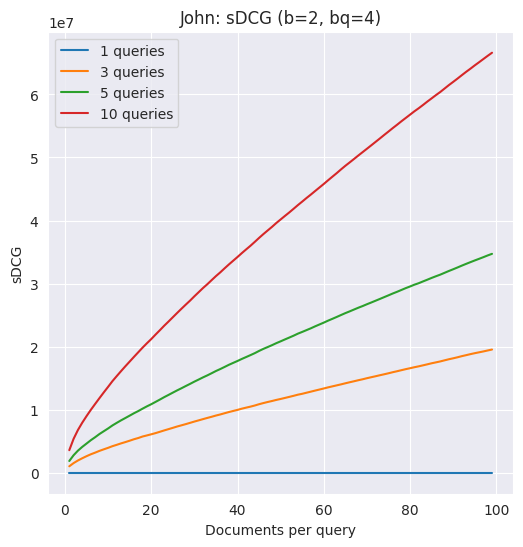

In [ ]:
df = pd.read_csv('sdcg_john.csv', index_col=0)
ax = df[['1 queries', '3 queries', '5 queries', '10 queries']].plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("John: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

In [ ]:
import math
from ranx import Qrels, Run, evaluate, compare, fuse, optimize_fusion

b = 2
bq = 4

qrels = qrels_dataset_sub

# run_dict[name][i-1][i].scores

run_store_markus = {}
for q in range(1, 11):
    run_store_markus[q] = Run.from_file("./bm25_markus_qno_" + str(q), kind='trec').to_dict()


qrels_store = {}
for k,v in qrels.items():
    for _v in v:
        qrels_store[(k,_v)] = qrels.get(k).get(_v)


def dcg(results, topic):
    _dcg = 0
    for i,result in enumerate(results):
        _doc = qrels_store.get(topic,result)
        if _doc is not None:
            _dcg += int(_doc) / (1 + math.log(i+1, b))

    return _dcg

data = {}
topics = qrels.keys()

for num_queries in range(1,11):
    _data = {}
    for num_docs in range(1, 100):
        run = {}
        for topic in topics:
            sdcg = 0.0
            for q in range(1, num_queries):
                results = list(run_store_markus.get(q).get(topic).keys())[:num_docs]
                sdcg += dcg(results, topic) / (1 + math.log(q + 1, bq))
            run[topic] = sdcg
        avg_sdcg = sum([sdcg for sdcg in run.values()])/len(topics)
        _data[num_docs] = avg_sdcg
    data[str(num_queries) + ' queries'] = _data

pd.DataFrame.from_dict(data).to_csv('sdcg_markus.csv')

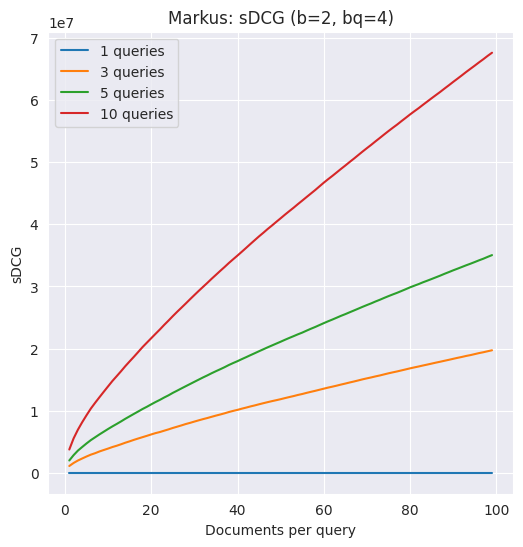

In [ ]:
df = pd.read_csv('sdcg_markus.csv', index_col=0)
ax = df[['1 queries', '3 queries', '5 queries', '10 queries']].plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("Markus: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

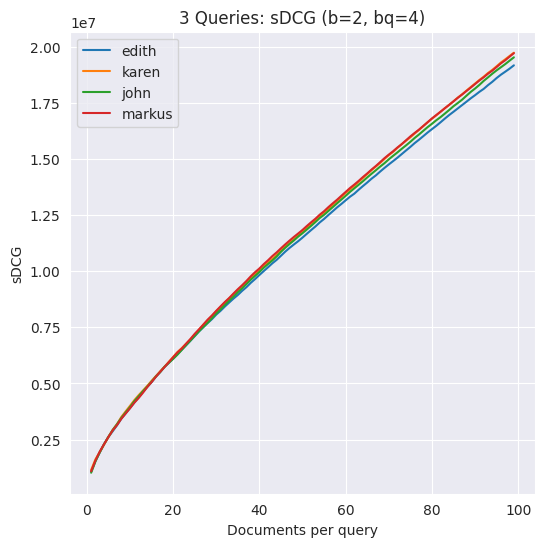

In [ ]:
df_edith = pd.read_csv('sdcg_edith.csv', index_col=0)
df_karen = pd.read_csv('sdcg_karen.csv', index_col=0)
df_john = pd.read_csv('sdcg_john.csv', index_col=0)
df_markus = pd.read_csv('sdcg_markus.csv', index_col=0)

queries_3 = pd.DataFrame()
queries_3["edith"] = df_edith["3 queries"]
queries_3["karen"] = df_karen["3 queries"]
queries_3["john"] = df_john["3 queries"]
queries_3["markus"] = df_markus["3 queries"]


ax = queries_3.plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("3 Queries: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

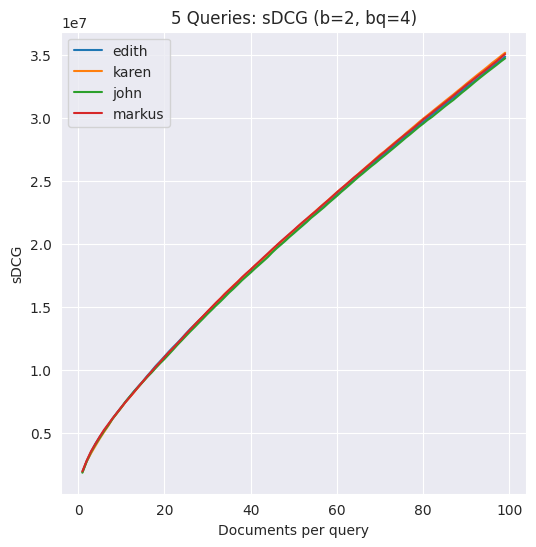

In [ ]:
queries_5 = pd.DataFrame()
queries_5["edith"] = df_edith["5 queries"]
queries_5["karen"] = df_karen["5 queries"]
queries_5["john"] = df_john["5 queries"]
queries_5["markus"] = df_markus["5 queries"]


ax = queries_5.plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("5 Queries: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()

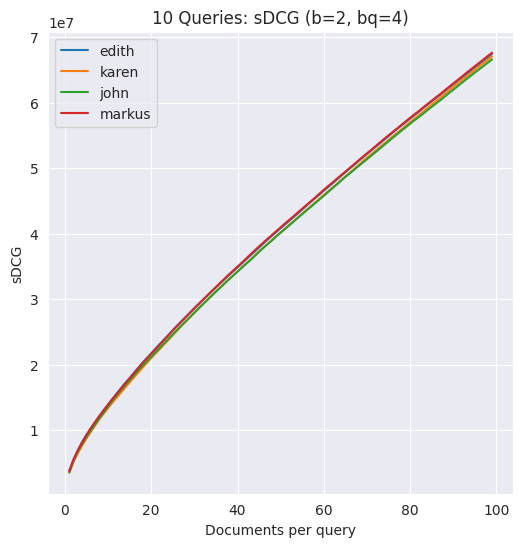

In [ ]:
queries_10 = pd.DataFrame()
queries_10["edith"] = df_edith["10 queries"]
queries_10["karen"] = df_karen["10 queries"]
queries_10["john"] = df_john["10 queries"]
queries_10["markus"] = df_markus["10 queries"]


ax = queries_10.plot(figsize=(6,6))
ax.set_xlabel("Documents per query")
ax.set_ylabel('sDCG')
plt.title("10 Queries: sDCG (b=2, bq=4)")
plt.savefig('sdcg.pdf', bbox_inches='tight')
plt.show()